In [1]:
import json
import torch
import torch.nn as nn

from pau import PAU

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from utils import init_sequential

import quad
import gc

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred/'
FIGURES_EIG = FIGURES / 'eigv/'
FIGURES_BASIS = FIGURES / 'basis/'
FIGURES_KERNEL = FIGURES / 'kernel/'
FIGURES_ERROR = FIGURES / 'error/'


FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_EIG.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)

PATH = Path('model')
ARCH = Path('arch')

savefig = False

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
Basis_name = 'S1_enc100_raw'
Basis_epoch = 10000

with open(ARCH / f'{Basis_name}.json', 'r') as f:
    Basis_params = json.load(f)

A = init_sequential(
    Basis_params['layers-apprx'],
    Basis_params['apprx-finish_with_activation'])

T = init_sequential(
    Basis_params['layers-trunk'],
    Basis_params['trunk-finish_with_activation'])

data = torch.load(PATH / Basis_params['name'] / f'{Basis_epoch}.model')

A.load_state_dict(data['A'][0])
T.load_state_dict(data['T'][0])

# T = torch.compile(T)
# A = torch.compile(A)

<All keys matched successfully>

In [3]:
Kernel_name = 'S2_qs100_raw'
Kernel_epoch = 1000

with open(ARCH / f'{Kernel_name}.json', 'r') as f:
    Kernel_params = json.load(f)

K = init_sequential(
    Kernel_params['layers'],
    Kernel_params['finish_with_activation'])

data = torch.load(PATH / Kernel_params['name'] / f'{Kernel_epoch}.model')

K.load_state_dict(data['K'][0])

# K = torch.compile(K)

<All keys matched successfully>

In [4]:
print(A)
print(T)
print(K)

Sequential(
  (0): Linear(in_features=100, out_features=8, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=8, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=1, bias=True)
)


In [5]:
N = 200
t = torch.linspace(0, 1, N)

Q = 100
int_p, int_w = quad.trapezoidal_rule(0, 1, Q)

In [6]:
def Basis_Model(xb, p):
    ''' (b, encdim), (M) -> (B, M, latdim) '''
    a = A(xb)
    b = T(p.unsqueeze(dim=1))
    return a @ b.T

In [7]:
def Kernel_Model(xb, t):
    n = len(t)
    m = xb.shape[1]
    int_p, int_w = quad.gaussian_quadrature(0, 1, m)
    
    result = torch.zeros(xb.shape[0], n)
    for j, t2 in enumerate(t):
        t1t2 = torch.stack((int_p, t2.expand(m))).T
        Kt1t2 = K(t1t2).squeeze()

        for i, xi in enumerate(xb):
            result[i, j] += (xi * Kt1t2) @ int_w
        
    return result

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


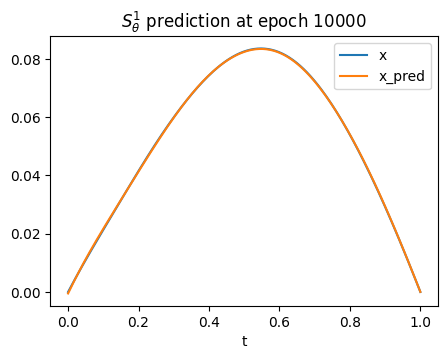

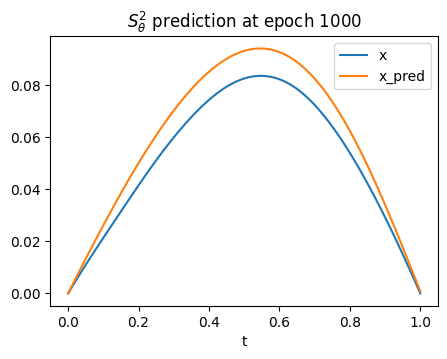

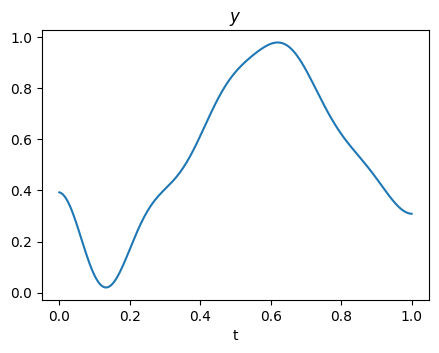

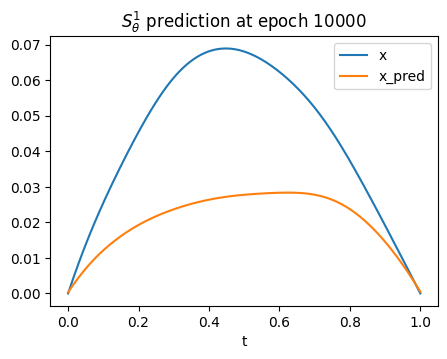

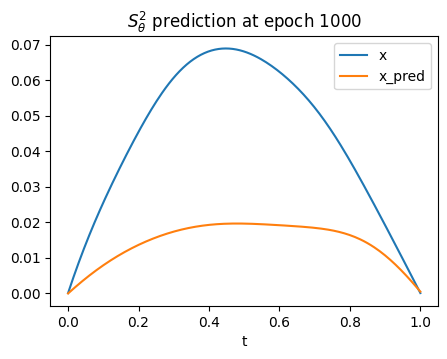

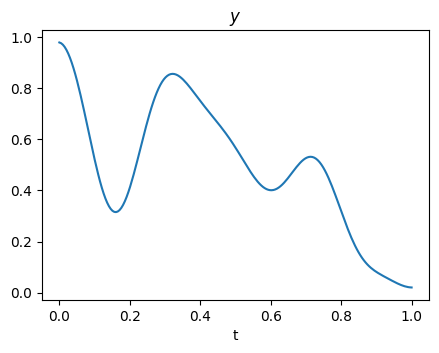

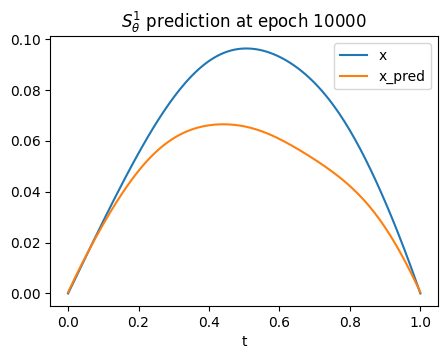

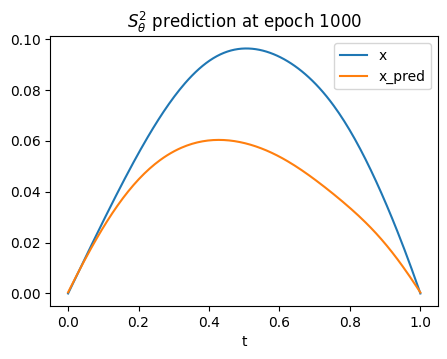

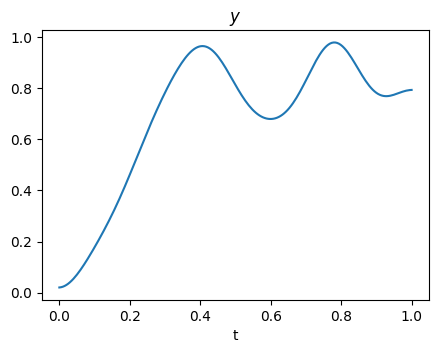

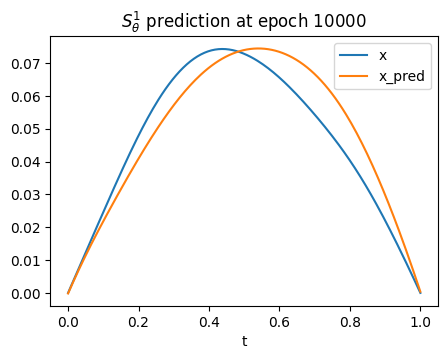

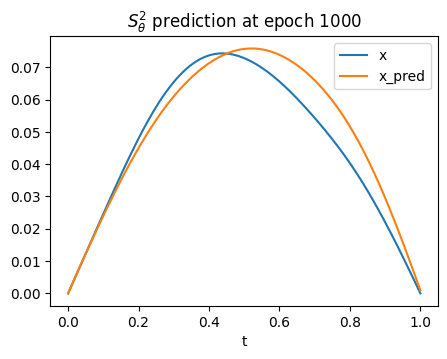

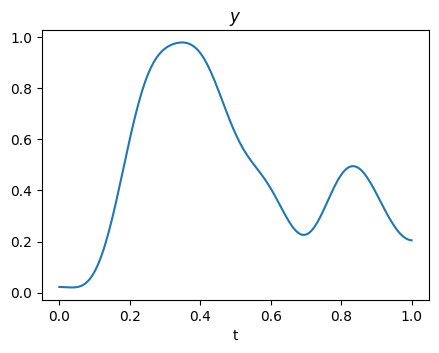

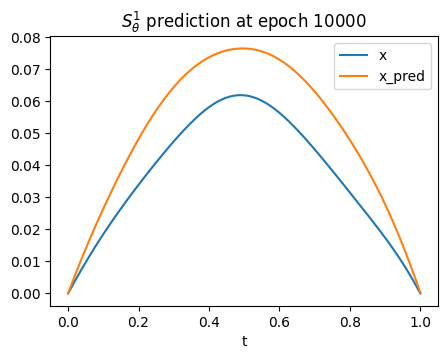

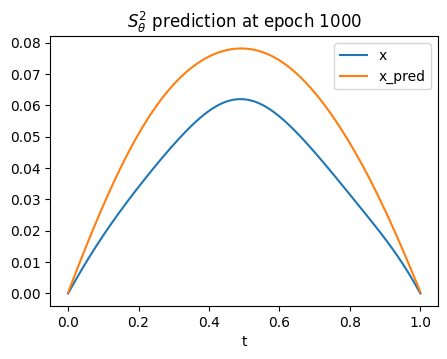

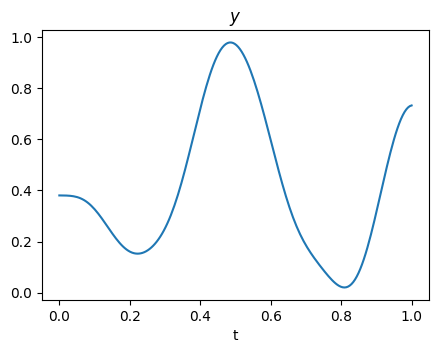

In [8]:
Basis_valid_ds = torch.load(PATH / Basis_params['name'] / 'valid.ds')
Kernel_valid_ds = torch.load(PATH / Kernel_params['name'] / 'valid.ds')

size = len(Basis_valid_ds[0])
step = size // 5

for i, idx in enumerate(range(0, size, step)):
    Kernel_y = Kernel_valid_ds[0][idx]
    Kernel_x_pred = Kernel_Model(Kernel_y.unsqueeze(dim=0), t).squeeze()

    Basis_y = Basis_valid_ds[0][idx]
    Basis_x_pred = Basis_Model(Basis_y.unsqueeze(dim=0), t).squeeze()

    x = torch.load(f'dataset/ds20k/valid/{i}_X.pt')
    y = torch.load(f'dataset/ds20k/valid/{i}_Y.pt')
    x = np.interp(t, np.linspace(0, 1, len(x)), x)
    y = np.interp(t, np.linspace(0, 1, len(y)), y)
    
    plt.figure(figsize=(5, 3.5))
    plt.plot(t, x, label='x')
    plt.plot(t, Basis_x_pred, label='x_pred')
    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_PRED / f'{Basis_params["name"]}_#epoch{Basis_epoch}_x_vs_xpred_#Fig{i}.png', bbox_inches = 'tight')
    plt.title(r'$S^1_{\theta}$ prediction at epoch ' + str(Basis_epoch))
    if savefig:
        plt.savefig(FIGURES_PRED / f'{Basis_params["name"]}_#epoch{Basis_epoch}_x_vs_xpred_#Fig{i}_with_title.png', bbox_inches = 'tight')
        plt.close()
    else: plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.plot(t, x, label='x')
    plt.plot(t, Kernel_x_pred, label='x_pred')
    plt.xlabel('t')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_PRED / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_x_vs_xpred_#Fig{i}.png', bbox_inches = 'tight')
    plt.title(r'$S^{2}_{\theta}$ prediction at epoch ' + str(Kernel_epoch))
    if savefig:
        plt.savefig(FIGURES_PRED / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_x_vs_xpred_#Fig{i}_with_title.png', bbox_inches = 'tight')
        plt.close()
    else: plt.show()
    
    plt.figure(figsize=(5, 3.5))
    plt.xlabel('t')
    plt.plot(t, y, label='y')
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_#Fig{i}.png', bbox_inches = 'tight')
    plt.title(r'$y$')
    if savefig:
        plt.savefig(FIGURES_PRED / f'y_#Fig{i}_with_title.png', bbox_inches = 'tight')
        plt.close()
    else: plt.show()

    gc.collect(2)

# Basis Extraction

In [9]:
class Function:
    def __init__(self, f1: callable = None):
        self.expr = []
        if f1: self.expr.append(f1)

    def copy(self):
        f = Function()
        f.expr = self.expr.copy()
        return f

    def __call__(self, x, *args, **kwargs):
        ans = self.expr[0](x)
        other = None
        for e in self.expr[1:]:
            if callable(e):
                other = e(x)
            elif not isinstance(e, str):
                other = e
            else:
                match e:
                    case '+': ans = ans + other
                    case '-': ans = ans - other
                    case '*': ans = ans * other
                    case '/': ans = ans / other
                    case '//': ans = ans // other
        return ans

    def __add_expr(self, other, expr: str):
        fun1 = Function()
        fun1.expr = self.expr.copy()

        if callable(other):
            fun2 = Function()
            fun2.expr = other.expr.copy()
            fun1.expr.append(fun2)
        elif isinstance(other, (int, float, complex)):
            fun1.expr.append(other)
        else:
            fun1.expr.append(other)

        fun1.expr.append(expr)

        return fun1

    def __add__(self, other): return self.__add_expr(other, '+')
    def __sub__(self, other): return self.__add_expr(other, '-')
    def __mul__(self, other): return self.__add_expr(other, '*')
    def __truediv__(self, other): return self.__add_expr(other, '/')
    def __div__(self, other): return self.__add_expr(other, '//')

In [10]:
N = 200
t = torch.linspace(0, 1, N)
tt = torch.dstack(torch.meshgrid(t, t, indexing='xy')).reshape(-1, 2)

In [11]:
def GramSchmidt(BASIS):
    V = BASIS
    n = len(V)
    Q = [None for _ in range(n)]
    R = [[0.0 for __ in range(n)] for _ in range(n)]
    
    for i in range(n):
        R[i][i] = torch.sqrt((V[i](int_p) * V[i](int_p)) @ int_w)
        Q[i] = V[i] / R[i][i]
        for j in range(i+1, n):
            R[i][j] = (V[j](int_p) * Q[i](int_p)) @ int_w
            if abs(R[i][j]) >= 1e-6:
                V[j] = V[j] - (Q[i] * R[i][j])
    return np.array(Q), R

In [12]:
def compute_EIGV(BASIS, MODEL):
    EIGV = []
    int_p, int_w = qua
    for i, b in enumerate(BASIS):
        bint = b(int_p)
        num = (bint * MODEL(bint.unsqueeze(dim=0), int_p)) @ int_w
        den = (bint * bint) @ int_w
        EIGV.append(num / den)
    
    return torch.tensor(EIGV)

## Basis Model

In [13]:
Basis_basis = []

Basis_basis_aux = T(t.unsqueeze(dim=1)).T
for b in Basis_basis_aux:
    def fun(x, b=b):
        return torch.tensor(np.interp(x, t.numpy(), b.numpy())).float()
    Basis_basis.append(Function(fun))

Basis_basis = np.array(Basis_basis)
Basis_eigv = compute_EIGV(Basis_basis, Basis_Model)

idx = torch.argsort(Basis_eigv, descending=True)

Basis_eigv = Basis_eigv[idx]
Basis_basis = Basis_basis[idx]

In [14]:
Basis_obasis, _ = GramSchmidt(Basis_basis)
Basis_oeigv = compute_EIGV(Basis_obasis, Basis_Model)

idx = torch.argsort(Basis_oeigv, descending=True)

Basis_oeigv = Basis_oeigv[idx]
Basis_obasis = Basis_obasis[idx]

## Kernel basis

In [15]:
Kernel_kernel = K(tt).squeeze().view(N, N)

U, S, _ = torch.linalg.svd(Kernel_kernel)

Kernel_basis_aux = U[:8].T
Kernel_eigv = sorted(1/S[:8], reverse=True)

In [16]:
Kernel_basis = []
for b in Basis_basis_aux:
    def fun(x, b=b):
        return torch.tensor(np.interp(x, t.numpy(), b.numpy())).float()
    Kernel_basis.append(Function(fun))

Kernel_basis = np.array(Kernel_basis)

Kernel_obasis, _ = GramSchmidt(Kernel_basis)
Kernel_oeigv = compute_EIGV(Kernel_obasis, Kernel_Model)

idx = torch.argsort(Kernel_oeigv, descending=True)

Kernel_oeigv = Kernel_oeigv[idx]
Kernel_obasis = Kernel_obasis[idx]

## Plotting

In [17]:
Real_basis = []
for k in range(1, 9):
    def fun(x, k=k):
        return torch.sin(torch.pi*k*x)
    Real_basis.append(Function(fun))


Real_basis, _ = GramSchmidt(np.array(Real_basis))
Real_eigv = [
    1/(torch.pi*k)**2
    for k in range(1, 9)
]

Basis

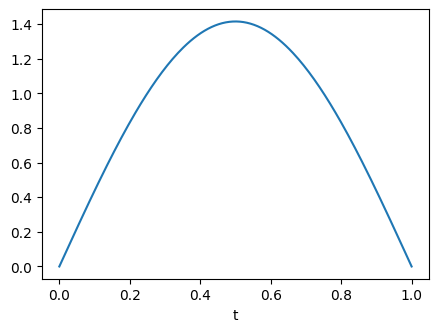

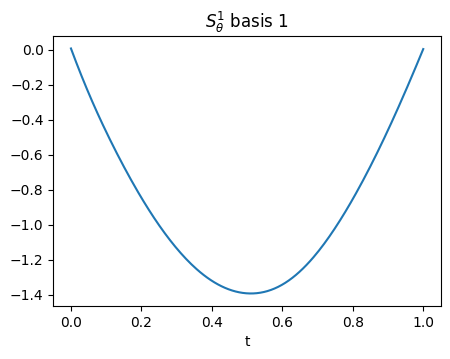

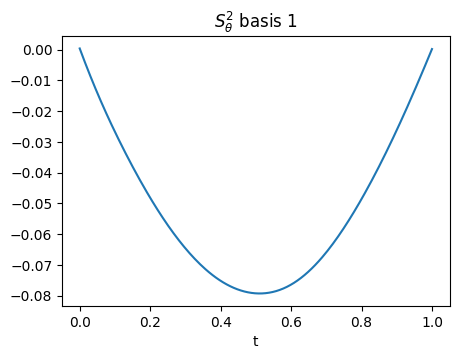

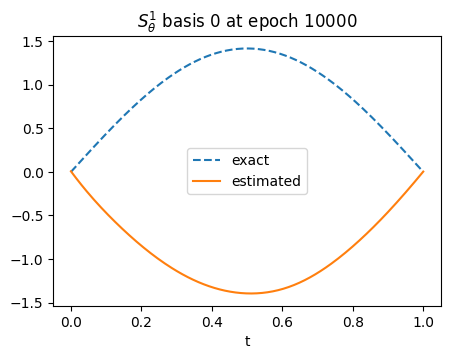

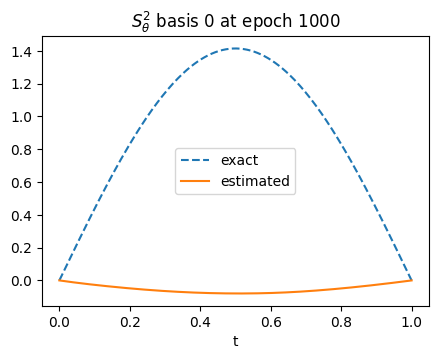

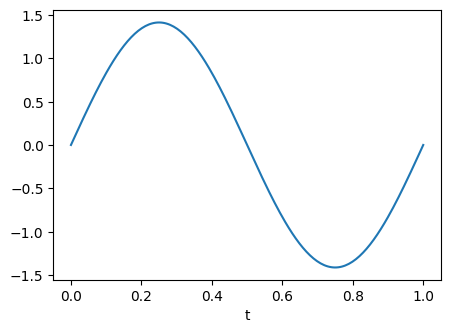

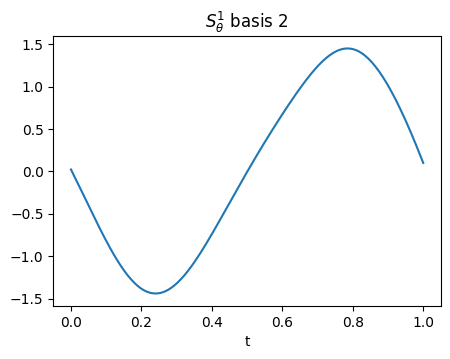

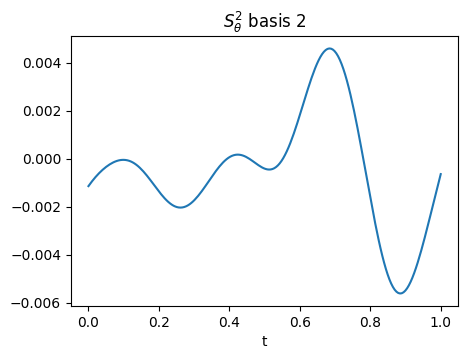

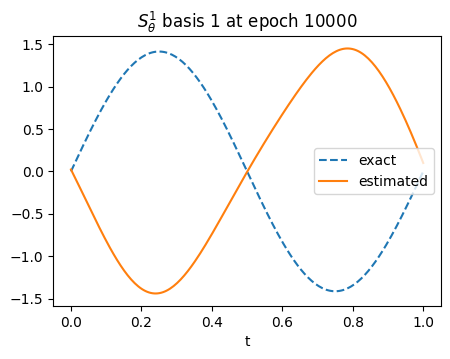

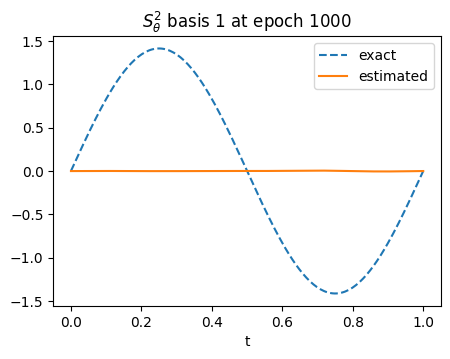

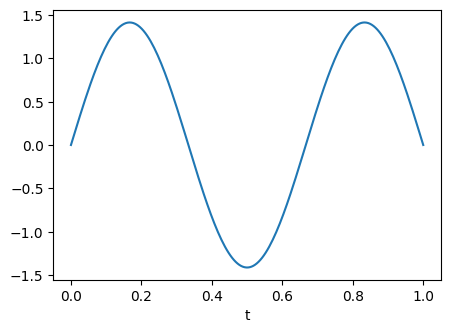

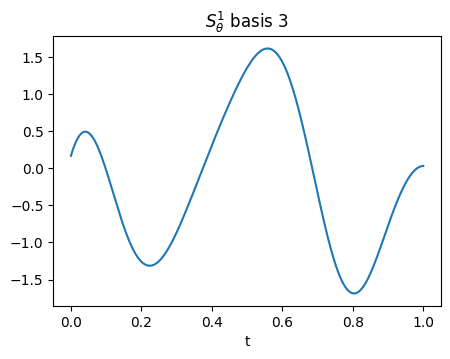

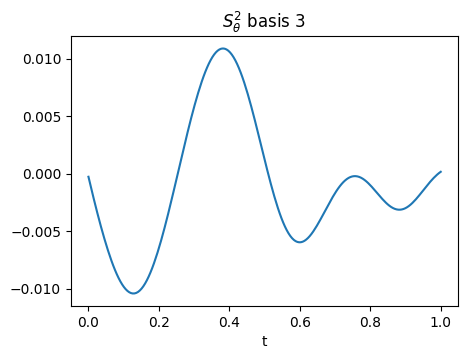

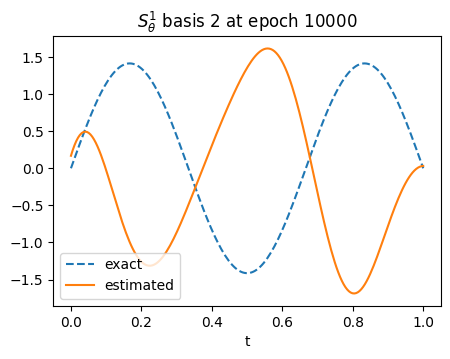

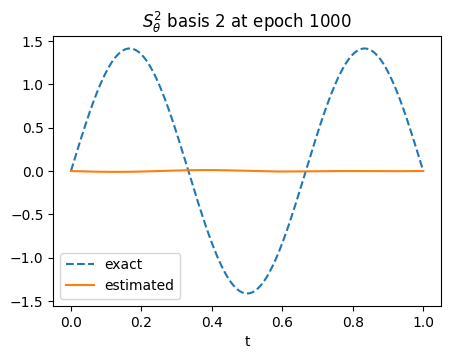

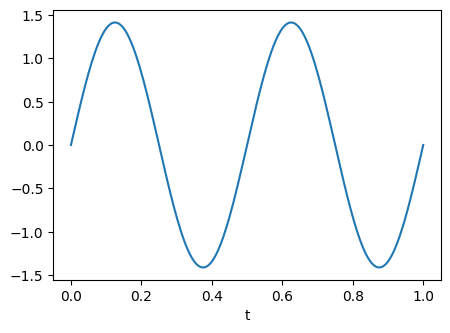

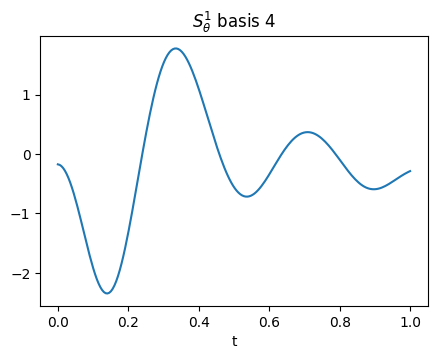

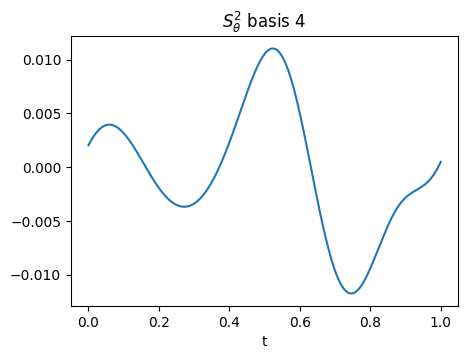

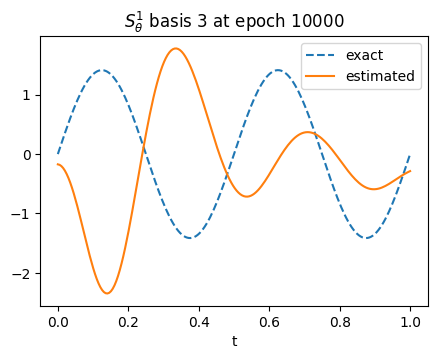

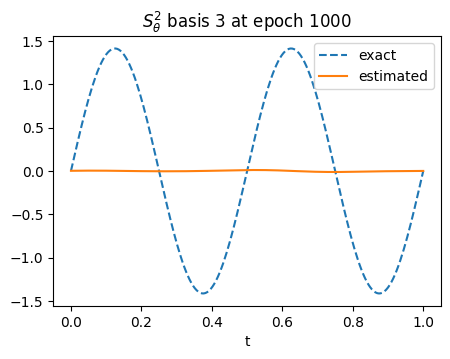

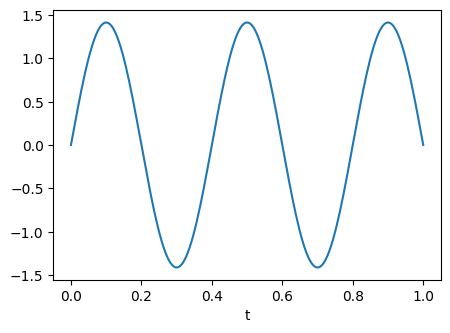

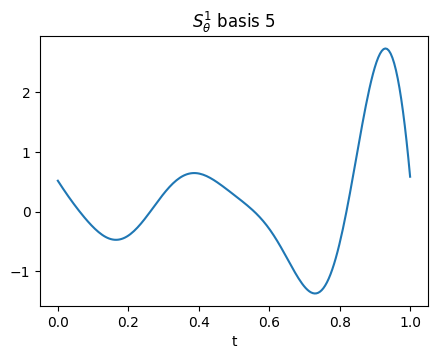

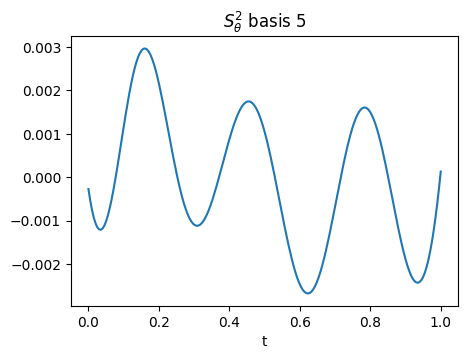

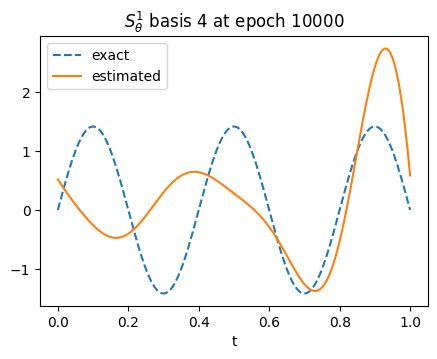

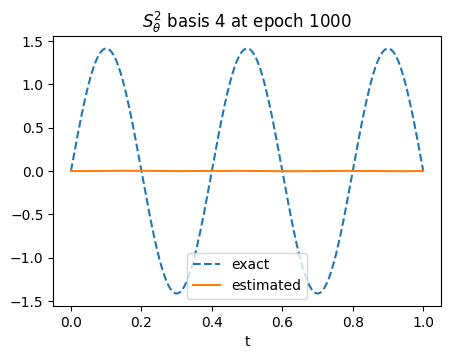

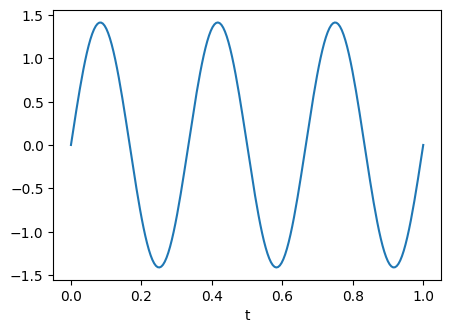

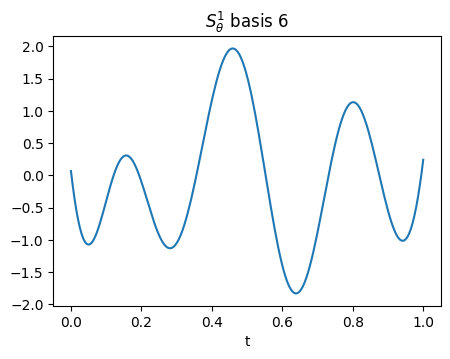

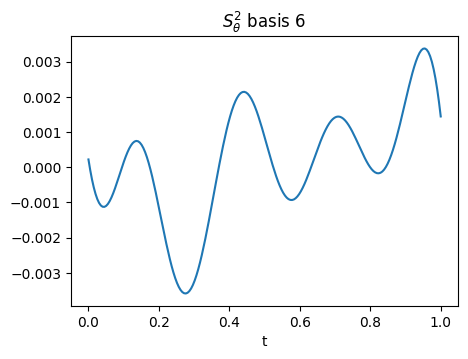

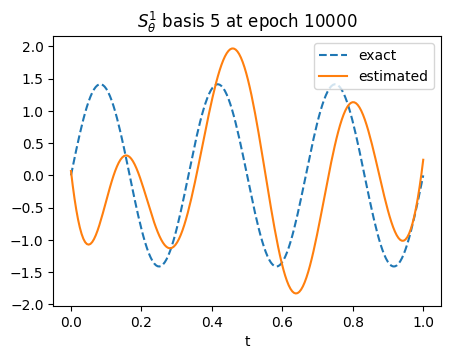

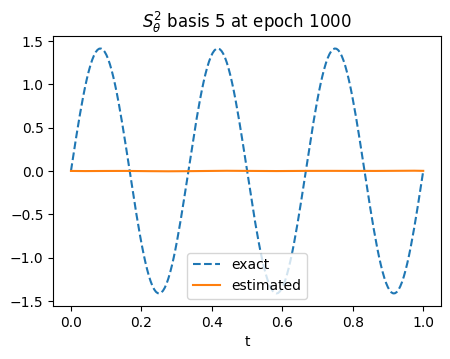

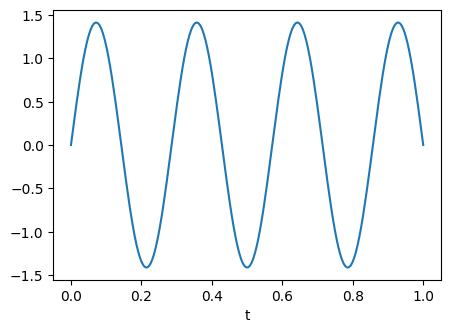

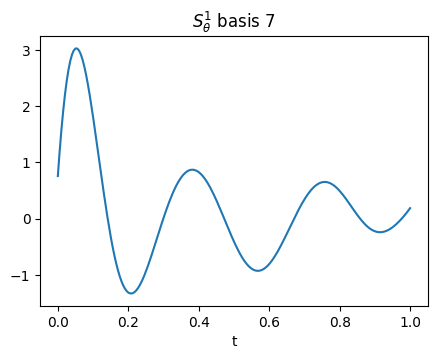

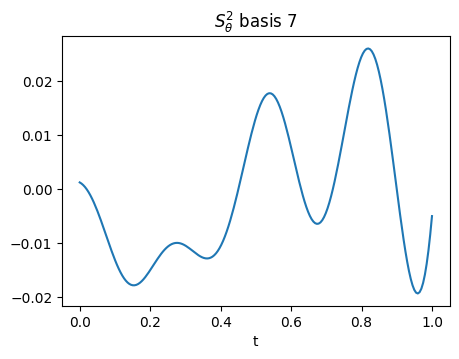

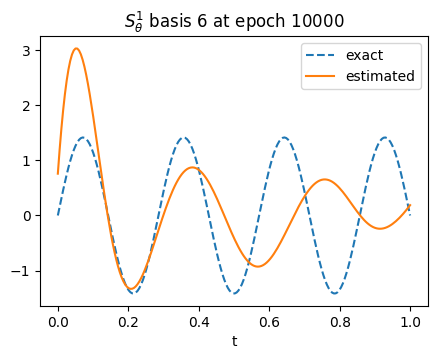

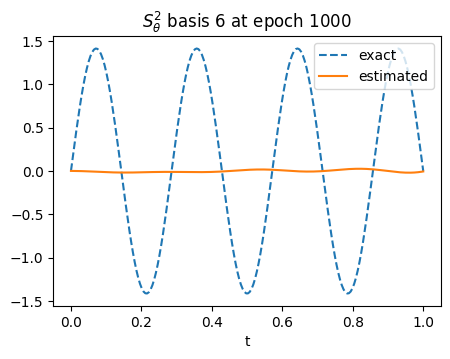

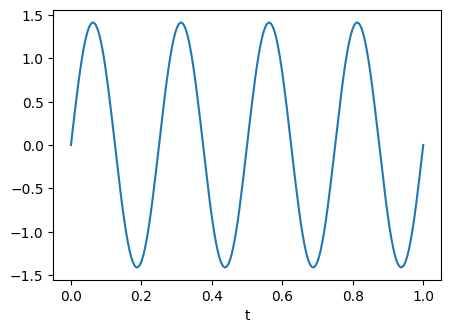

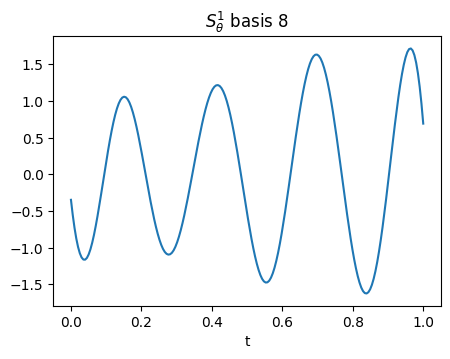

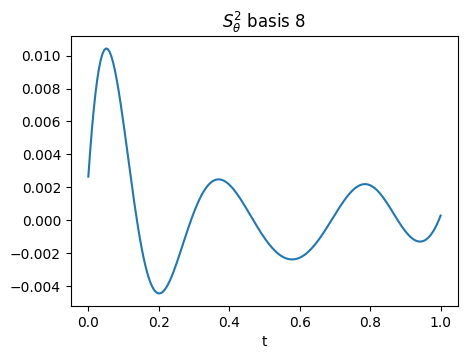

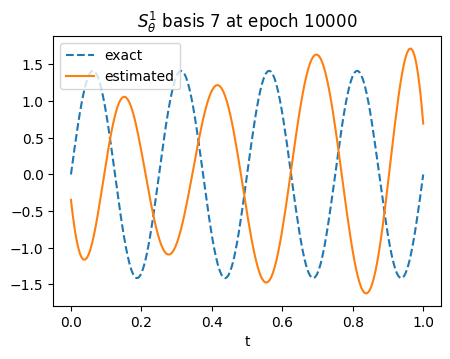

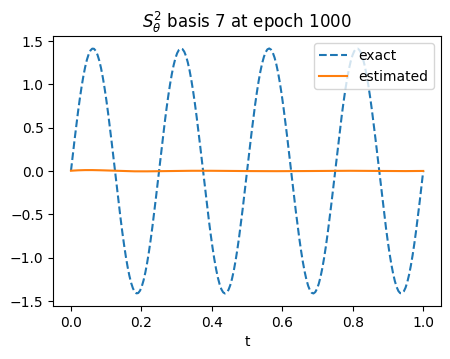

In [18]:
for i in range(8):
    plt.figure(figsize=(5,3.5))
    plt.xlabel('t')
    plt.plot(t, Real_basis[i](t))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'#Fig{i}', bbox_inches='tight')
        plt.close()
    else: plt.show()

    plt.figure(figsize=(5,3.5))
    plt.xlabel('t')
    plt.plot(t, Basis_obasis[i](t))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Basis_params["name"]}_#epoch{Basis_epoch}_#Fig{i}.png', bbox_inches='tight')
    plt.title(r'$S^1_{\theta}$' + f' basis {i+1}')
    if savefig:
            plt.savefig(FIGURES_BASIS / f'{Basis_params["name"]}_#epoch{Basis_epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
    else: plt.show()
    
    plt.figure(figsize=(5,3.5))
    plt.xlabel('t')
    plt.plot(t, Kernel_basis[i](t))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_#Fig{i}.png', bbox_inches='tight')
    plt.title(r'$S^2_{\theta}$' + f' basis {i+1}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
        plt.close()
    else: plt.show()

    #  With background
    plt.figure(figsize=(5,3.5))
    plt.xlabel('t')
    plt.plot(t, Real_basis[i](t), '--', label='exact')
    plt.plot(t, Basis_obasis[i](t), label='estimated')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Basis_params["name"]}_#epoch{Basis_epoch}_#Fig{i}_with_bg.png', bbox_inches='tight')
    plt.title(r'$S^1_{\theta}$' + f' basis {i} at epoch {Basis_epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Basis_params["name"]}_#epoch{Basis_epoch}_#Fig{i}_with_bg_with_title.png', bbox_inches='tight')
        plt.close()
    else: plt.show()
    
    plt.figure(figsize=(5,3.5))
    plt.xlabel('t')
    plt.plot(t, Real_basis[i](t), '--', label='exact')
    plt.plot(t, Kernel_basis[i](t), label='estimated')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_#Fig{i}_with_bg.png', bbox_inches='tight')
    plt.title(r'$S^2_{\theta}$' + f' basis {i} at epoch {Kernel_epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_#Fig{i}_with_bg_with_title.png', bbox_inches='tight')
        plt.close()
    else: plt.show()

Eigv

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(Real_eigv, 'or-', label='exact')
plt.plot(Basis_oeigv, 'ob-', label='estimated')
plt.title(r'$S^1_{\theta}$ eigenvalue estimation at epoch ' + str(Basis_epoch)) 
plt.legend()
if savefig:
    plt.savefig(FIGURES_EIG / f'{Basis_params["name"]}_#epoch{Basis_epoch}_with_title.png', bbox_inches='tight')

plt.figure(figsize=(5, 4))
plt.plot(Real_eigv, 'or-', label='exact')
plt.plot(Kernel_oeigv, 'ob-', label='estimated')
plt.title(r'$S^2_{\theta}$ eigenvalue estimation at epoch ' + str(Kernel_epoch))
plt.legend()
if savefig:
    plt.savefig(FIGURES_EIG / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_with_title.png', bbox_inches='tight')

# Kernel Extraction

In [ ]:
def compute_kernel(BASIS, EIGV):
    s = torch.zeros(8, NT, NT)
    for i in range(len(BASIS)):
        s[i] = torch.outer(BASIS[i](t), BASIS[i](t)) * EIGV[i]
    
    return torch.sum(s, axis=0)

In [ ]:
Exact_kernel = torch.zeros(tt.shape[0])
cond = tt[:, 0] < tt[:, 1]
Exact_kernel[cond] = tt[cond, 0] * (1 - tt[cond, 1])
Exact_kernel[~cond] = tt[~cond, 1] * (1 - tt[~cond, 0])
Exact_kernel = Exact_kernel.reshape(N, N)

In [ ]:
Trunc_kernel = torch.zeros(N, N)

for i in range(8):
    Trunc_kernel += torch.outer(Real_basis[i](t), Real_basis[i](t)) * Real_eigv[i]

In [ ]:
Basis_kernel = torch.zeros(N, N)

for i in range(8):
    Basis_kernel += torch.outer(Basis_obasis[i](t), Basis_obasis[i](t)) * Basis_oeigv[i]

In [ ]:
'''  Save Separate Files  '''
plt.figure(figsize=(5, 5))
plt.imshow(Exact_kernel, cmap='jet')
plt.title('Exact kernel')
plt.axis('off')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'exact_with_title.png', bbox_inches='tight')
    plt.close()
else: plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(Trunc_kernel, cmap='jet')
plt.title('Truncated kernel')
plt.axis('off')
if savefig:
    plt.savefig(FIGURES_KERNEL / 'trunc_with_title.png', bbox_inches='tight')
    plt.close()
else: plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(Basis_kernel, cmap='jet')
plt.title(r'$S^1_{\theta}$ kernel at epoch ' + str(Basis_epoch))
plt.axis('off')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{Basis_model["name"]}_#epoch{Basis_epoch}_with_title.png', bbox_inches='tight')
    plt.close()
else: plt.show()


plt.figure(figsize=(5, 5))
plt.imshow(Kernel_kernel, cmap='jet')
plt.title(r'$S^2_{\theta}$ kernel at epoch ' + str(Kernel_epoch))
plt.axis('off')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{Kernel_params["name"]}_#epoch{Kernel_epoch}_with_title.png', bbox_inches='tight')
    plt.close()
else: plt.show()

# Errors

In [ ]:
def read_error_log(logfile, rf, max_epoch=-1):
    error = []
    with open(logfile) as f:
        for line in f.readlines():
            epoch, err = line.split(',')

            if max_epoch > 0 and int(epoch) > max_epoch:
                break
            
            if int(epoch) % rf == 0:
                error.append(float(err))

    return error

In [ ]:
Basis_rf = Basis_epoch // 10
Kernel_rf = Kernel_epoch // 10

Basis_valid_error = read_error_log(PATH / Basis_params['name'] / 'valid.error', Basis_rf, Basis_epoch)
Basis_train_error = read_error_log(PATH / Basis_params['name']  / 'train.error', Basis_rf, Basis_epoch)

Kernel_valid_error = read_error_log(PATH / Kernel_params['name'] / 'valid.error', Kernel_rf, Kernel_epoch)
Kernel_train_error = read_error_log(PATH / Kernel_params['name'] / 'train.error', Kernel_rf, Kernel_epoch)

In [ ]:
Basis_epoch_timeline = [k for k in range(0, Basis_epoch, Basis_rf)]

plt.figure(figsize=(8, 7))

plt.loglog(Basis_epoch_timeline, Basis_valid_error, 'ob-', label='validation error', linewidth=0.5)
plt.loglog(Basis_epoch_timeline, Basis_train_error, 'or-', label='training error', linewidth=0.5)
plt.xlabel('epoch')
plt.ylabel('mean relative L2 error')
plt.title(r'$S^1_{\theta}$' + f' training and validation error evolution until epoch {Basis_epoch}')
plt.tight_layout()
plt.legend()
if savefig:
    plt.savefig(FIGURES_ERROR / f'basis_model_#epoch{Basis_epoch}_with_title.png')

In [ ]:
Kernel_epoch_timeline = [k for k in range(0, Kernel_epoch, Kernel_rf)]

plt.figure(figsize=(8, 7))

plt.loglog(Kernel_epoch_timeline, Kernel_valid_error, 'ob-', label='validation error', linewidth=0.5)
plt.loglog(Kernel_epoch_timeline, Kernel_train_error, 'or-', label='training error', linewidth=0.5)

plt.xlabel('epoch')
plt.ylabel('mean relative L2 error')

plt.title(r'$S^2_{\theta}$' + f' training an validation error at epoch {Kernel_epoch}')

plt.tight_layout()
plt.legend()

if savefig:
    plt.savefig(FIGURES_ERROR / f'kernel_model_#epoch{Kernel_epoch}_with_title.png')

# Basis Evolution

In [ ]:
Basis_rf = Basis_epoch // 10
Basis_epoch_timeline = [k for k in range(0, Basis_epoch, Basis_rf)]

T = init_sequential(Basis_params['layers-trunk'])

values = torch.zeros(Basis_epoch // Basis_rf, len(t), 8)
for i, k in enumerate(Basis_epoch_timeline):
    data = torch.load(PATH / Basis_name / f'{k}.model')
    T.load_state_dict(data['T'][0])

    values[i] = T(t.unsqueeze(dim=1)).squeeze()

In [ ]:
for i in range(8):
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    plt.tight_layout()

    for j, k in enumerate(Basis_epoch_timeline):
        ax.plot(k, t, values[j, :, i], linewidth=5)
    
    ax.set_xlabel('epoch')
    ax.set_title(fr'$\tau_{i+1}$', fontsize=20)
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Basis_params["name"]_evolution_#epoch{Basis_epoch}_#Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
for i in range(8):
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    plt.tight_layout()

    for j, k in enumerate(Basis_epoch_timeline[1:], start=1):
        ax.plot(k, t, values[j, :, i], linewidth=5)
    
    ax.set_xlabel('epoch')
    ax.set_title(fr'$\tau_{i+1}$', fontsize=20)
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{Basis_params["name"]}_evolution_#epoch{Basis_epoch}_#Fig{i}_without_first_with_title.png', bbox_inches='tight')
    plt.close()